<a href="https://colab.research.google.com/github/yurikobyzev/yurikobyzev/blob/main/XRAYCHECK_HQ_SAM_GROUNDING_DINO_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/XRAYCHECK

/content/drive/MyDrive/XRAYCHECK


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 10.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

best='/content/drive/MyDrive/XRAYCHECK/runs/detect/yolov8n_v8_50e7/weights/best.pt'
model = YOLO(best)

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

#!git clone https://github.com/SysCV/sam-hq.git
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor


PyTorch version: 2.0.1+cu118
CUDA is available: True


In [ ]:
#!mkdir pretrained_checkpoint
#!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
#!mv sam_hq_vit_l.pth pretrained_checkpoint

In [ ]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    print('box:',box)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        #print(mask.shape,mask)
        show_mask(mask, plt.gca(), random_color=True)
    #for box in input_box:
        #print(box.shape,box)
        #show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [ ]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

<All keys matched successfully>


In [ ]:
testpath='/content/drive/MyDrive/XRAYCHECK/phphph-2/test/images/01-10-2021_2_png.rf.0ea79b55a6a35c70066d1e8a1cd9c492.jpg'

In [ ]:
testpath='/content/drive/MyDrive/XRAYCHECK/ph_final/pistolet/select/2017-10-07T10-44-25_286_pistolet.jpg'

In [ ]:
results = model.predict(source=testpath, conf=0.01)


image 1/1 /content/drive/MyDrive/XRAYCHECK/ph_final/pistolet/select/2017-10-07T10-44-25_286_pistolet.jpg: 1280x512 8 0s, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1280, 512)


In [ ]:
bbox=[]
for result in results:
    boxes = result.boxes
    for bb in boxes:
      bbox.append(bb.xyxy.tolist()[0])
print(bbox)

[[262.1909484863281, 509.68634033203125, 302.43603515625, 589.1306762695312], [239.24696350097656, 527.3157958984375, 261.24591064453125, 569.1983642578125], [59.62476348876953, 524.7393798828125, 85.51155090332031, 538.27197265625], [261.017578125, 510.7319030761719, 286.4481201171875, 574.1989135742188], [148.80557250976562, 524.6298217773438, 171.67726135253906, 562.4451904296875], [269.3492126464844, 568.2310791015625, 301.0415344238281, 587.7051391601562], [125.56517791748047, 432.4230651855469, 168.10903930664062, 481.459228515625], [184.66827392578125, 210.5827178955078, 222.6761474609375, 238.76377868652344]]


In [ ]:
image = cv2.imread(testpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array(bbox)

#print(input_box.shape,input_box)
input_point, input_label = None, None
predictor.set_image(image)
allmasks=[]
for i in range(len(bbox)):
  print('box ',i, input_box[i])
  masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      box = input_box[i],
      multimask_output=False,
      hq_token_only= False,
  )
  #print(masks.shape)
  allmasks.append(masks[0])

#print(allmasks)

box  0 [     262.19      509.69      302.44      589.13]
box  1 [     239.25      527.32      261.25       569.2]
box  2 [     59.625      524.74      85.512      538.27]
box  3 [     261.02      510.73      286.45       574.2]
box  4 [     148.81      524.63      171.68      562.45]
box  5 [     269.35      568.23      301.04      587.71]
box  6 [     125.57      432.42      168.11      481.46]
box  7 [     184.67      210.58      222.68      238.76]


Score: 0.891


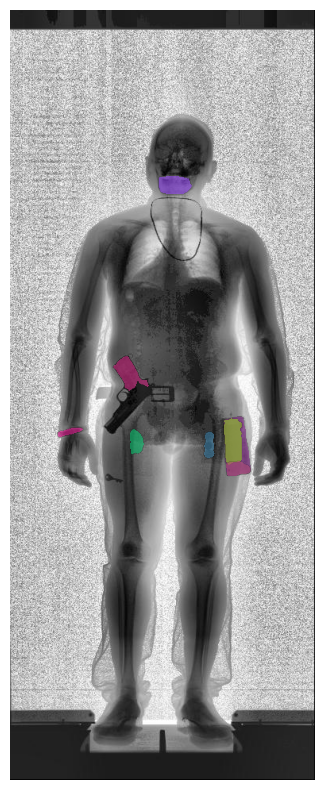

In [ ]:
show_res_multi(allmasks,scores,input_point, input_label, input_box, image)